In [2]:
#this allows plots to be displayed inline with the notebook
%matplotlib inline 

In [3]:
import os.path

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
from losspager.models.semimodel import SemiEmpiricalFatality,make_test_semi_model,URBAN,RURAL,pop_dist

Here we are demonstrating the "interactive" use of the SemiEmpirical PAGER Loss model. The first thing we have to do is find the necessary input files in the repository where this notebook lives.

In [6]:
homedir = os.getcwd()
invfile = os.path.join(homedir,'..','test','data','semi_inventory.hdf')
colfile = os.path.join(homedir,'..','test','data','semi_collapse_mmi.hdf')
fatfile = os.path.join(homedir,'..','test','data','semi_casualty.hdf')
workfile = os.path.join(homedir,'..','test','data','semi_workforce.hdf')
growthfile = os.path.join(homedir,'..','test','data','WPP2015_POP_F02_POPULATION_GROWTH_RATE.xls')

Next, we create a SemiEmpiricalFatality object using those files.

In [7]:
semi = SemiEmpiricalFatality.loadFromFiles(invfile,colfile,fatfile,workfile,growthfile)

Establish the parameters which we'd like to test - country code, time of day, population density, input population, and MMI.

In [8]:
ccode = 'ID' #Indonesia
timeofday = 'day'
density = URBAN
pop = 100000
mmi = 8.5

The <a http://earthquake.usgs.gov/data/pager/prodandref/Jaiswal_Wald_2010_Semi.pdf>paper</a> describing this model in full says that Indonesia daytime residential/non-residential populations should be about 22% and 43% of the total respectively (the remainder are outdoors, and therefore relatively safe from shaking.)   

In [9]:
workforce = semi.getWorkforce(ccode)
res,nonres,outside = pop_dist(pop,workforce,timeofday,density)
print(workforce)
print('Daytime Residential Population of %s: %s' % (ccode,format(int(res[0]),',d')))
print('Daytime Non-Residential Population of %s: %s' % (ccode,format(int(nonres[0]),',d')))

CountryName              Indonesia
WorkForceTotal               0.461
WorkForceAgricultural        0.433
WorkForceIndustrial           0.18
WorkForceServices            0.387
Name: ID, dtype: object
Daytime Residential Population of ID: 22,021
Daytime Non-Residential Population of ID: 43,525


Retrieve the residential/non-residential urban inventories for Indonesia - these are returned as Pandas Series objects

In [10]:
resinv,nonresinv = semi.getInventories(ccode,density)
print('Residential:')
print(resinv)
print()
print('Non-Residential:')
print(nonresinv)

Residential:
C2       0.1
C3      0.15
PC2     0.03
S5      0.05
UCB      0.4
UFB4    0.12
W        0.1
W1      0.05
Name: ID, dtype: object

Non-Residential:
C2      0.15
C3      0.35
PC2     0.04
S2      0.17
S5      0.14
UCB      0.1
UFB4    0.05
Name: ID, dtype: object


Retrieve the collapse rates for both inventories at MMI 8.5.

In [11]:
res_collapse = semi.getCollapse(ccode,mmi,resinv)
nonres_collapse = semi.getCollapse(ccode,mmi,nonresinv)
print('Residential Collapse Rates:')
print(res_collapse)
print()
print('Non-Residential Collapse Rates:')
print(nonres_collapse)

Residential Collapse Rates:
C2      0.0100
C3      0.0650
PC2     0.1050
S5      0.0075
UCB     0.0650
UFB4    0.1270
W       0.0750
W1      0.0225
Name: MMI_8.5, dtype: float64

Non-Residential Collapse Rates:
C2      0.0100
C3      0.0650
PC2     0.1050
S2      0.0250
S5      0.0075
UCB     0.0650
UFB4    0.1270
Name: MMI_8.5, dtype: float64


Retrieve the daytime fatality rates given collapse for both inventories.

In [12]:
res_fat_rates = semi.getFatalityRates(ccode,timeofday,resinv)
nonres_fat_rates = semi.getFatalityRates(ccode,timeofday,nonresinv)
print('Residential Fatality Rates:')
print(res_fat_rates)
print()
print('Non-Residential Fatality Rates:')
print(nonres_fat_rates)

Residential Fatality Rates:
C2      0.150
C3      0.150
PC2     0.150
S5      0.140
UCB     0.080
UFB4    0.080
W       0.007
W1      0.007
Name: CasualtyDay, dtype: float64

Non-Residential Fatality Rates:
C2      0.15
C3      0.15
PC2     0.15
S2      0.14
S5      0.14
UCB     0.08
UFB4    0.08
Name: CasualtyDay, dtype: float64


Now we can multiply the residential/non-residential populations through the inventory, collapse, and fatality rates.

In [13]:
res_fats = res * resinv * res_collapse * res_fat_rates
nonres_fats = nonres * nonresinv * nonres_collapse * nonres_fat_rates
print('Residential Fatalities:')
print(res_fats)
print()
print('Non-Residential Fatalities:')
print(nonres_fats)
print()
resfatsum = int(res_fats.sum())
nonresfatsum = int(nonres_fats.sum())
print('Total Residential Fatalities: %s' % (format(resfatsum,',d')))
print('Total Non-Residential Fatalities: %s' % (format(nonresfatsum,',d')))
print('Total Fatalities: %s' % (format(nonresfatsum+resfatsum,',d')))

Residential Fatalities:
C2       3.30315
C3       32.2057
PC2      10.4049
S5        1.1561
UCB      45.8037
UFB4      26.848
W         1.1561
W1      0.173415
dtype: object

Non-Residential Fatalities:
C2      9.79319
C3       148.53
PC2     27.4209
S2      25.8975
S5      6.39822
UCB     22.6331
UFB4    22.1108
dtype: object

Total Residential Fatalities: 121
Total Non-Residential Fatalities: 262
Total Fatalities: 383


Because the production version of the model isn't exactly implemented as above (the code is vectorized to take advantage of numpy speed), the semimodel module has a test method that creates a 1x1 grid which is then used in the SemiEmpiricalFatality.getLosses() method.  This is a better test of the full method than the "manual" methods above.

In [14]:
losses,resfat,nonresfat = make_test_semi_model(invfile,colfile,fatfile,workfile,growthfile,ccode,timeofday,density,pop,mmi)
print(losses)

383


Series objects have a built-in plot() method, which can take many forms - in this case, a pie chart.  Let's compare the *inventory* pie chart to the *fatality* pie chart.

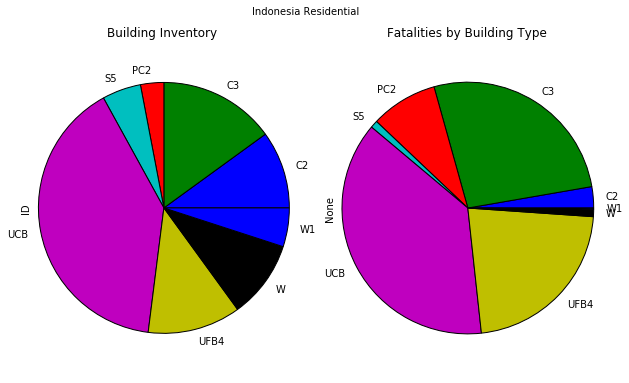

In [15]:
resfat2 = res_fats/resfatsum
fig,axlist = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
ax1 = axlist[0]
ax2 = axlist[1]
plt.subplot(ax1)
resinv.plot(kind='pie',ax=ax1)
ph=plt.title('Building Inventory')
plt.axis('equal')
plt.subplot(ax2)
resfat2.plot(kind='pie',ax=ax2)
plt.axis('equal')
ph=plt.title('Fatalities by Building Type')
ph = plt.suptitle('Indonesia Residential')

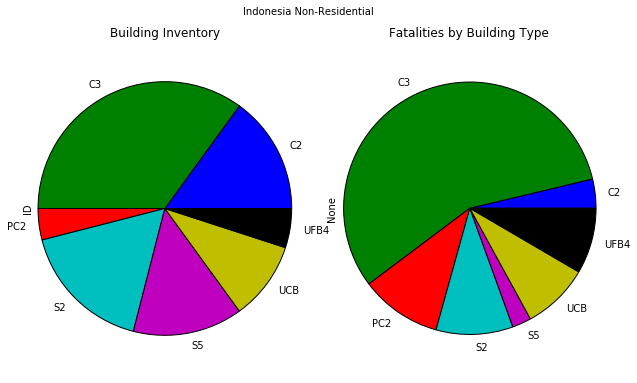

In [16]:
nonresfat2 = nonres_fats/resfatsum
fig,axlist = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
ax1 = axlist[0]
ax2 = axlist[1]
plt.subplot(ax1)
nonresinv.plot(kind='pie',ax=ax1)
ph=plt.title('Building Inventory')
plt.axis('equal')
plt.subplot(ax2)
nonresfat2.plot(kind='pie',ax=ax2)
plt.axis('equal')
ph=plt.title('Fatalities by Building Type')
ph = plt.suptitle('Indonesia Non-Residential')

So we have shown how to calculate fatalities for one population value in one "cell" with a given density class and MMI.  How about for a whole ShakeMap?  First we need to inform the model about our population, country code, and urban/rural grids.

In [17]:
popfile = os.path.join(homedir,'..','test','data','eventdata','northridge','northridge_gpw.flt')
urbfile = os.path.join(homedir,'..','test','data','eventdata','northridge','northridge_urban.bil')
isofile = os.path.join(homedir,'..','test','data','eventdata','northridge','northridge_isogrid.bil')
shakefile = os.path.join(homedir,'..','test','data','eventdata','northridge','northridge_grid.xml')
popyear = 2012
semi.setGlobalFiles(popfile,popyear,urbfile,isofile)

Then we call the getLosses() method with the Northridge ShakeMap as input:

In [18]:
loss,resfbystruct,nonresfbystruct = semi.getLosses(shakefile)
print('Total estimated losses for Northridge: %s' % format(loss,',d'))

Total estimated losses for Northridge: 539


It turns out for Northridge the model estimates 0 fatalities in non-residential buildings, but we can examine the residential structures:

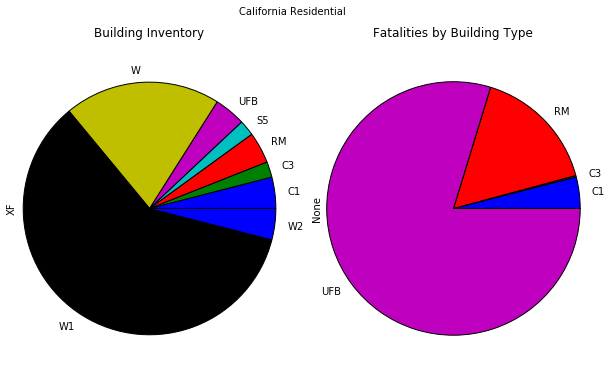

In [19]:
resinv,nresinv = semi.getInventories('XF',URBAN)
fig,axlist = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
ax1 = axlist[0]
ax2 = axlist[1]
plt.subplot(ax1)
resinv.plot(ax=ax1,kind='pie')
plt.title('Building Inventory');
plt.axis('equal');
plt.subplot(ax2)
resfat = pd.Series(resfbystruct['XF'])
resfat2 = resfat/resfat.sum()
resfat2.plot(kind='pie',ax=ax2)
plt.title('Fatalities by Building Type');
plt.axis('equal');
plt.suptitle('California Residential');

We have a method getBuildingDesc() that will expand the building codes:

In [20]:
for btype,numfat in resfbystruct['XF'].items():
    bdesc = semi.getBuildingDesc(btype,'operational')
    print('%40s (%3s) fatalities: %4s' % (bdesc.capitalize(),btype,format(int(numfat),',d')))
#df = pd.DataFrame(resfbystruct['XF'])
#df

               Reinforced concrete frame ( C1) fatalities:   21
      Concrete frame with masonry infill ( C3) fatalities:    1
                      Reinforced masonry ( RM) fatalities:   86
              Unreinforced brick masonry (UFB) fatalities:  430
                        Light wood frame ( W1) fatalities:    0
                        Heavy wood frame ( W2) fatalities:    0
                                    Wood (  W) fatalities:    0
         Steel frame with masonry infill ( S5) fatalities:    0
